# ML-IMC

In [1]:
using Dates
using Plots
using Statistics
using LinearAlgebra
using Distributed

if nworkers() == 1
    BLAS.set_num_threads(1)
    addprocs(4)
end

@everywhere begin
    include("src/distances.jl")
    include("src/readLJ.jl")
    include("src/ML-IMC.jl");
end

## 1. The first iteration

## 1.1. Input data 

In [3]:
bins, rdfref, histref = readRDF("rdf-mean-p40.dat")
histref ./= 500;

In [4]:
xyz = readXYZ("mctraj-p001.xyz")
conf = xyz[end]

parameters = readinput("LJML-init.in")

model = Dense(length(histref), 1, bias=true);

Reading mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


In [68]:
η = 0.005 # learning rate

0.005

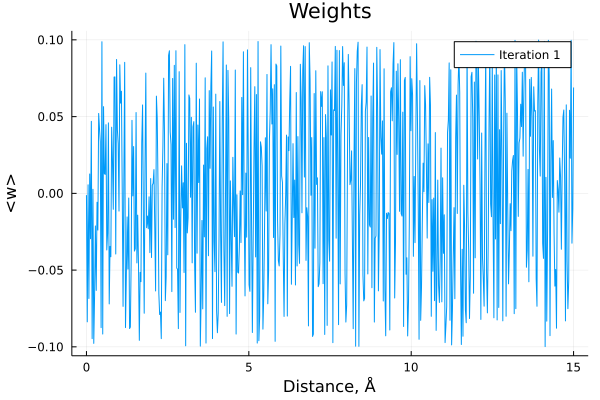

In [37]:
plot(bins, model.weight', title="Weights", label="Iteration 1")
xlabel!("Distance, Å")
ylabel!("<w>")

## 1.2. Running the simulation

In [5]:
function main(conf, parameters, model)    
    # Start the timer
    startTime = Dates.now()
    println("Running MC simulation on $(nworkers()) rank(s)...\n")
    println("Total number of steps: $(parameters.steps * nworkers() / 1E6)M")
    println("Starting at: ", startTime)
    
    # Prepare inputs
    input = conf, parameters, model
    inputs = [input for worker in workers()]
    
    # Run the simulation in parallel
    outputs = pmap(mcrun!, inputs)
    
    # Stop the timer
    stopTime = Dates.now()
    wallTime = Dates.canonicalize(stopTime - startTime)
    println("Stopping at: ", stopTime, "\n")
    println("Walltime: ", wallTime)
    
    return(outputs)
end;

In [6]:
outputs = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 4.0M
Starting at: 2022-03-25T13:27:19.588
      From worker 5:	Acceptance ratio = 0.364964
      From worker 3:	Acceptance ratio = 0.366432
      From worker 4:	Acceptance ratio = 0.365578
      From worker 2:	Acceptance ratio = 0.36681
Stopping at: 2022-03-25T13:28:29.133

Walltime: 1 minute, 9 seconds, 545 milliseconds


# 1.3 Analyzing

In [75]:
histNN = mean([output[1] for output in outputs]);

In [76]:
energies = mean([output[2] for output in outputs]);

In [78]:
length(parameters.Eqsteps:parameters.outfreq:parameters.steps)

501

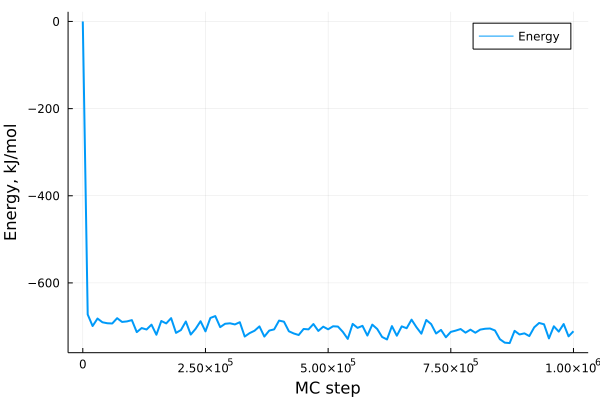

In [71]:
slicing = Int(1E1)
steps = parameters.Eqsteps:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy")
xlabel!("MC step")
ylabel!("Energy, kJ/mol")

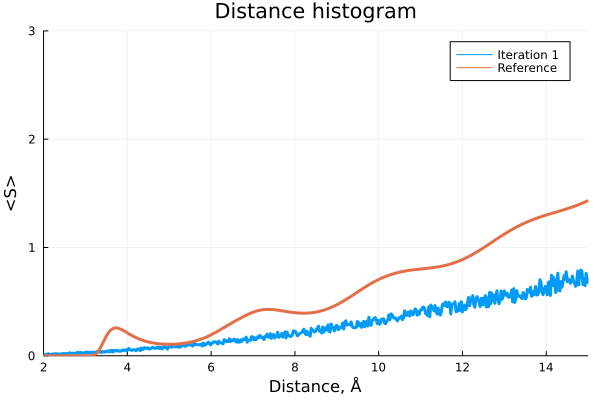

In [72]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 1", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [73]:
loss(histNN, histref)

67.36454611440398

In [74]:
crossWeights = mean([output[3] for output in outputs])
crossBiases = mean([output[4] for output in outputs]);

In [39]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, model, parameters);

In [40]:
updatemodel!(model, 0.005, dLdw, dLdb);

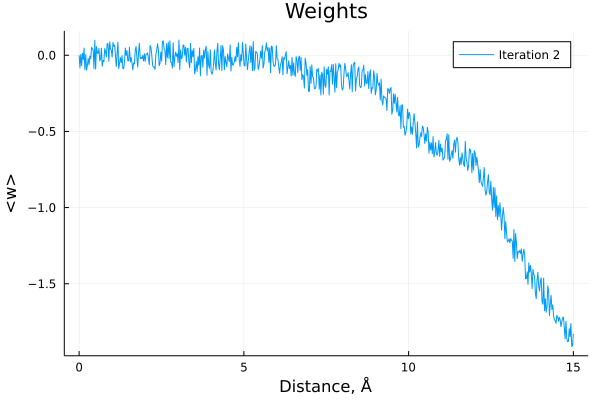

In [44]:
plot(bins, model.weight', title="Weights", label="Iteration 2")
xlabel!("Distance, Å")
ylabel!("<w>")

# 2. Second iteration

In [18]:
outputs2 = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 4.0M
Starting at: 2022-03-25T13:30:55.904
      From worker 4:	Acceptance ratio = 0.017636
      From worker 5:	Acceptance ratio = 0.017792
      From worker 3:	Acceptance ratio = 0.017906
      From worker 2:	Acceptance ratio = 0.018533
Stopping at: 2022-03-25T13:31:27.502

Walltime: 31 seconds, 598 milliseconds


In [45]:
histNN = mean([output[1] for output in outputs2]);

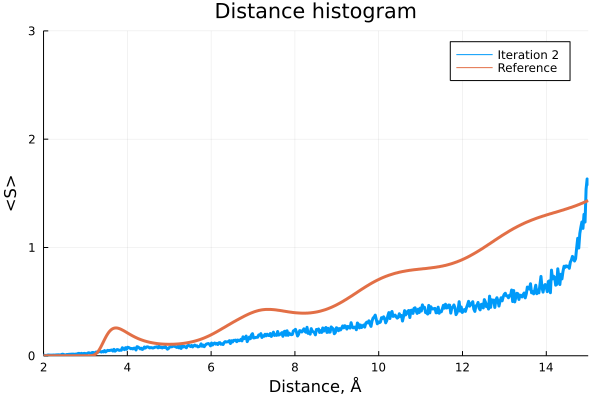

In [46]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 2", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [47]:
loss(histNN, histref)

59.490698949904

In [49]:
crossWeights = mean([output[3] for output in outputs2])
crossBiases = mean([output[4] for output in outputs2]);

In [50]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, model, parameters);

In [51]:
updatemodel!(model, 0.005, dLdw, dLdb);

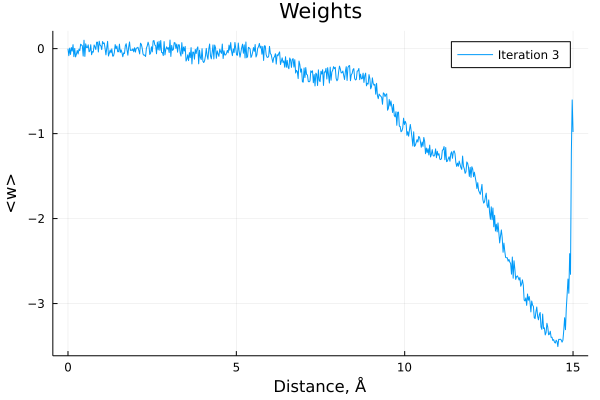

In [52]:
plot(bins, model.weight', title="Weights", label="Iteration 3")
xlabel!("Distance, Å")
ylabel!("<w>")

# 3. Third iteration

In [53]:
outputs3 = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 4.0M
Starting at: 2022-03-25T13:38:11.690
      From worker 5:	Acceptance ratio = 0.019169
      From worker 2:	Acceptance ratio = 0.018744
      From worker 4:	Acceptance ratio = 0.018732
      From worker 3:	Acceptance ratio = 0.018583
Stopping at: 2022-03-25T13:38:43.289

Walltime: 31 seconds, 599 milliseconds


In [54]:
histNN = mean([output[1] for output in outputs3]);

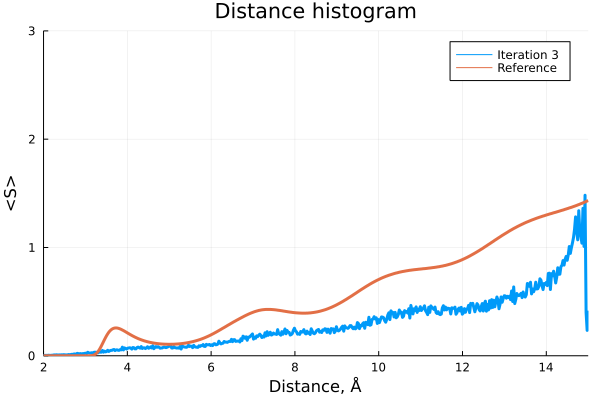

In [55]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 3", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [56]:
loss(histNN, histref)

60.59682374340401

In [57]:
crossWeights = mean([output[3] for output in outputs3])
crossBiases = mean([output[4] for output in outputs3]);

In [58]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, model, parameters);

In [59]:
updatemodel!(model, 0.005, dLdw, dLdb);

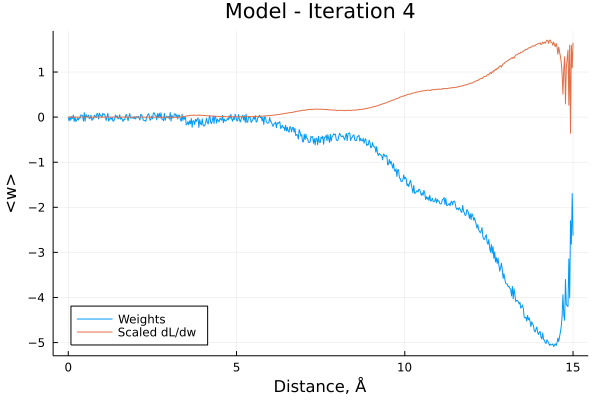

In [67]:
plot(bins, model.weight', title="Model - Iteration 4", label="Weights", legend=:bottomleft)
plot!(bins, dLdw*0.005, label="Scaled dL/dw")
xlabel!("Distance, Å")
ylabel!("<w>")

# 4. Fourth iteration

In [56]:
outputs4 = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 0.4M
Starting at: 2022-03-25T10:56:30.193
      From worker 2:	Acceptance ratio = 0.04239
      From worker 5:	Acceptance ratio = 0.04267
      From worker 3:	Acceptance ratio = 0.04178
      From worker 4:	Acceptance ratio = 0.04193
Stopping at: 2022-03-25T10:56:33.100

Walltime: 2 seconds, 907 milliseconds


In [57]:
histNN = mean([output[1] for output in outputs4]);

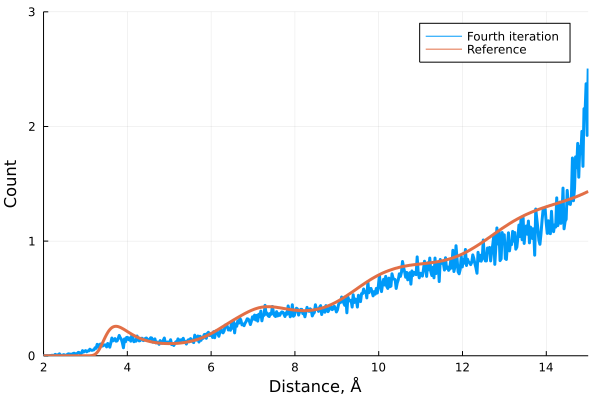

In [58]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Fourth iteration")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

In [59]:
loss(histNN, histref)

8.909029628904001

# 5. Some more iterations

In [60]:
for i in 1:10
    println("Iteration $i...")
    outputs_more = main(conf, parameters, model)
    histNN = mean([output[1] for output in outputs_more])
    println("Loss = ", loss(histNN, histref))
    crossWeights = mean([output[3] for output in outputs_more])
    crossBiases = mean([output[4] for output in outputs_more])
    dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, model, parameters)
    updatemodel!(model, 0.005, dLdw, dLdb)
end;

Iteration 1...
Running MC simulation on 4 rank(s)...

Total number of steps: 0.4M
Starting at: 2022-03-25T10:59:01.224
      From worker 2:	Acceptance ratio = 0.0415
      From worker 5:	Acceptance ratio = 0.04278
      From worker 3:	Acceptance ratio = 0.04276
      From worker 4:	Acceptance ratio = 0.04166
Stopping at: 2022-03-25T10:59:04.069

Walltime: 2 seconds, 845 milliseconds
Loss = 8.848564448904002
Iteration 2...
Running MC simulation on 4 rank(s)...

Total number of steps: 0.4M
Starting at: 2022-03-25T10:59:04.171
      From worker 2:	Acceptance ratio = 0.04251
      From worker 5:	Acceptance ratio = 0.04231
      From worker 3:	Acceptance ratio = 0.04204
      From worker 4:	Acceptance ratio = 0.04328
Stopping at: 2022-03-25T10:59:07.068

Walltime: 2 seconds, 897 milliseconds
Loss = 8.970006838903998
Iteration 3...
Running MC simulation on 4 rank(s)...

Total number of steps: 0.4M
Starting at: 2022-03-25T10:59:07.073
      From worker 2:	Acceptance ratio = 0.04194
      From

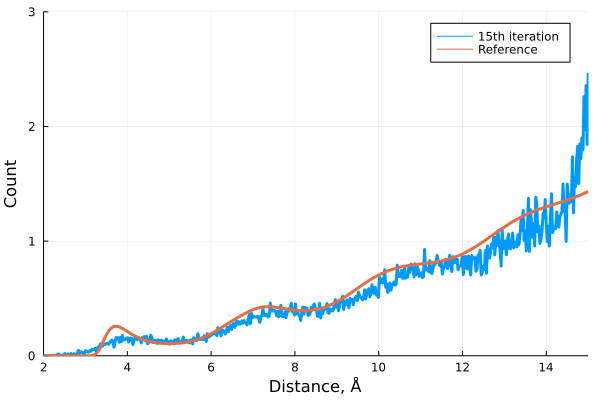

In [61]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="15th iteration")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")